<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Очистка-и-лемматизация-данных" data-toc-modified-id="Очистка-и-лемматизация-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация данных</a></span></li><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разделение данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Цель исследования: Построить модель со значением метрики качества *F1* не меньше 0.75.

Ход исследования:
1. Загрузка данных
2. Обзор данных
3. Очитска данных
4. Лемматизация данных
5. Векторизация данных
6. Разбивка данных
7. Обучение моделей
8. Тестирование
9. Проверка на адекватность
10. Общий вывод

## Подготовка

### Обзор данных

In [1]:
# импорт модулей
! pip install catboost
import pandas as pd
import re
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_validate
)
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [2]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
     data = pd.read_csv('https://code.s3.yandex.net//datasets/toxic_comments.csv')

In [3]:
# первые строки
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
# информация о столбцах
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


### Очистка и лемматизация данных

In [5]:
data['text'] = data['text'].astype('U')

In [6]:
# удаляем все кроме английских слов приводим к нижнему регистру
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return ' '.join(text.split()).lower()

data['lemm'] = data['text'].apply(clear_text)

data.head(10)

,Unnamed: 0,text,toxic,lemm
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulations from me as well use the tools ...
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense was offensive to yo...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


In [7]:
# загружаем датасет с лемматизированным текстом
# если сохраненного датасета нет, то делаем лемматизацию и сохраняем
# (т.к. процесс лемматизации занимает много времени)

try:
    data = pd.read_csv('toxic_comments_lemm.csv')
except:
    # языковая модель
    nlp = spacy.load("en_core_web_sm")

    # функция для лемматизации
    def lemmatize(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    data['lemm'] = data['text'].apply(lemmatize)
    data.to_csv('toxic_comments_lemm.csv')

data.head(10)

,Unnamed: 0,text,toxic,lemm
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation \n why the edit make under my user...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! he match this background colour I be s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , I be really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,""" \n More \n I can not make any real suggestio..."
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."
5,5,"""\n\nCongratulations from me as well, use the ...",0,""" \n\n congratulation from I as well , use the..."
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER before you pis around on MY work
7,7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the Matt Shirvington article...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word ' nonsense ' be offensive to...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


### Разделение данных

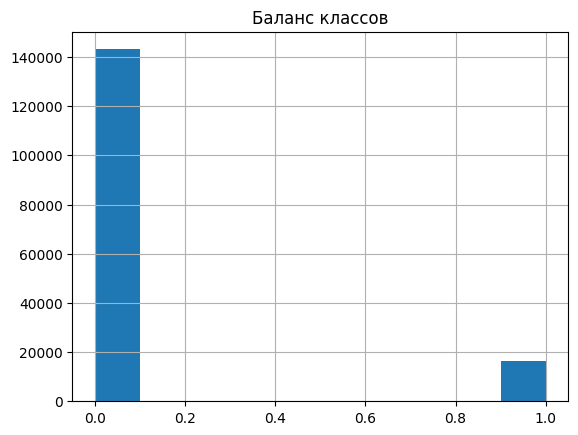

In [8]:
# анализ баланса классов
data['toxic'].hist()
plt.title('Баланс классов')
plt.show()

Классы несбалансированы, поэтому разбиваем на выборки со стратификацией по целевой переменной.

In [9]:
# разделение выборки на обучающую и тестовую
features = data['lemm']
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            stratify=target, random_state=96)
print('Размер фрейма признаков обучающей выборки:', features_train.shape)
print('Размер фрейма целевого признака обучающей выборки:', target_train.shape)
print('Размер фрейма признаков тестовой выборки:', features_test.shape)
print('Размер фрейма целевого признака тестовой выборки:', target_test.shape)

Размер фрейма признаков обучающей выборки: (119469,)
Размер фрейма целевого признака обучающей выборки: (119469,)
Размер фрейма признаков тестовой выборки: (39823,)
Размер фрейма целевого признака тестовой выборки: (39823,)


Т.к. во время подбора параметров для CatBoost тратится много времени и кросс-валидация заканчивается отключением ядра, уменьшим выборки для этого алгоритма.

In [10]:
# берем 1000 строк для обучающей выборки и 333 для тестовой. Тем самым сохраним отношение (75%:25%)
features_train_boost = features_train.sample(n=1000, random_state=96)
target_train_boost = target_train.sample(n=1000, random_state=96)
features_test_boost = features_test.sample(n=333, random_state=96)
target_test_boost = target_test.sample(n=333, random_state=96)

**Вывод:** В этой главе мы провели подготовку данных к обучению. Обзор данных показал нам размерность датасета, отсутствие пропусков и типы данных столбцов.
Далее мы оставили в текстах только английские символы и привели к нижнему регистру. С помощью библиотеки spacy мы провели лемматизацию текста.

Мы разделили датасет на тренировочную и тестовую выборку в соотношении (75%:25%).  Анализ целевых классов показал, что они несбалансированы. Поэтому при разделении мы использовали стратификацию по целевой переменной. Наконец мы удалили английские стоп-слова.

Дополнительно мы сделали тренировочную и тестовую выборку для модели CatBoost, имеющие 1000 и 333 строк соответственно. Позже для них провели векторизацию.

## Обучение

### Логистическая регрессия

In [11]:
%%time
# используем class_weight='balanced' чтобы придать меньшему классу больший вес
model_reg = LogisticRegression(random_state=96, class_weight='balanced', max_iter=1000)

# объявляем векторайзер и список стоп-слов
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))
vect = TfidfVectorizer(stop_words=stopwords)

# настройка пайплайна
pipeline_reg = Pipeline(
    [
        ("vect", vect),
        ("model_reg", model_reg),
    ]
)

param_grid_reg = {
                  'model_reg__C':[0.01, 0.1, 1, 10, 100]
}
gs_reg = GridSearchCV(pipeline_reg,
                      param_grid=param_grid_reg,
                      scoring='f1',
                      n_jobs=-1
                     )
gs_reg.fit(features_train, target_train)

print(f'F1: {gs_reg.best_score_}')
print(f'Лучшие параметры: {gs_reg.best_params_}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


F1: 0.7626861243657042
Лучшие параметры: {'model_reg__C': 10}
CPU times: user 37.6 s, sys: 29.1 s, total: 1min 6s
Wall time: 6min 33s


### Случайный лес

In [12]:
%%time
# случайный лес
model_rf = RandomForestClassifier(random_state=96, class_weight='balanced')

# настройка пайплайна
pipeline_rf = Pipeline(
    [
        ("vect", vect),
        ("model_rf", model_rf),
    ]
)

param_grid_rf = {
    'model_rf__n_estimators': range(50, 201, 50),
    'model_rf__max_depth': range(2, 16),
}

gs_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    scoring='f1',
    n_jobs=-1,
    random_state=96
)

gs_rf.fit(features_train, target_train)

print(f'F1: {gs_rf.best_score_}')
print(f'Лучшие параметры: {gs_rf.best_params_}')

F1: 0.36607866407130174
Лучшие параметры: {'model_rf__n_estimators': 50, 'model_rf__max_depth': 15}
CPU times: user 26.5 s, sys: 6.47 s, total: 33 s
Wall time: 9min 50s


### Градиентный бустинг

In [13]:
# рассчитаем веса классов
classes = np.unique(target_train_boost)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train_boost)
class_weights = dict(zip(classes, weights))

In [14]:
%%time
# модель градиентного бустинга
model_boost = CatBoostClassifier(random_state=96,
                                 verbose=False, class_weights=class_weights)

# настройка пайплайна
pipeline_boost = Pipeline(
    [
        ("vect", vect),
        ("model_boost", model_boost),
    ]
)

param_grid_boost = {
    'model_boost__iterations': range(10, 51, 10),
    'model_boost__max_depth': range(2, 11),
    'model_boost__learning_rate': (0.1, 0.2, 0.3, 0.4)
}

gs_boost = RandomizedSearchCV(
    pipeline_boost,
    param_distributions=param_grid_boost,
    scoring='f1',
    n_jobs=-1,
    random_state=96
)

gs_boost.fit(features_train_boost, target_train_boost)

print(f'F1: {gs_boost.best_score_}')
print(f'Лучшие параметры: {gs_boost.best_params_}')

F1: 0.47324199775812675
Лучшие параметры: {'model_boost__max_depth': 8, 'model_boost__learning_rate': 0.2, 'model_boost__iterations': 50}
CPU times: user 14.6 s, sys: 4.28 s, total: 18.8 s
Wall time: 3min 29s


Мы определили конвейеры, содержащие векторизатор и модели для классификации текстов.

Наилучший показатель F1 = 0.76 показала модель логистической регрессии с параметрами {C=10; max_iter=1000}. Эта модель показала достаточный результат F1 и она отправляется на тестирование.

На втором месте с показателем F1 = 0.47 модель CatBoost с параметрами {'max_depth': 8, 'learning_rate': 0.2, 'iterations': 50}.

Хуже всех показала себя модель случайного леса с F1 = 0.37 и параметрами {'n_estimators': 50, 'max_depth': 15}.

### Тестирование

In [15]:
# тестирование модели логистической регрессии
pred = gs_reg.predict(features_test)
print('F1 на тестовой выборке:', f1_score(target_test, pred))

F1 на тестовой выборке: 0.7693376563223715


Модель прошла тест.

### Проверка на адекватность

In [16]:
# создадим константный массив
ones = np.ones(len(target_test))
print('F1 константной модели:', f1_score(target_test, ones))

F1 константной модели: 0.18445827349609065


**Вывод:**
Модель логистической регрессии с F1 = 0.77 показала лучший результат чем константная модель F1 = 0.18.
Проверка на адекватность пройдена. Модель логистической регрессии может идти в производство.

Другие модели:
- CatBoost: F1 = 0.47, параметры {'max_depth': 8, 'learning_rate': 0.2, 'iterations': 50}.
- Модель случайного леса: F1 = 0.37, параметры{'n_estimators': 50, 'max_depth': 15}

## Выводы

Мы провели исследование данных с комментариями на предмет их токсичности. Заказчиком был интернет-магазин «Викишоп». Он запускает новый сервис с возможностью редактирования описания товаров, как в вики-сообществах, и им нужен инструмент для поиска токсичных комментариев для их дальнейшей отправки на модерацию.

Процесс подготовки данных включал в себя:
- обзор данных
- очистка от символов не входящих в английский алфавит и стоп-слов
- приведение к нижнему регистру
- лемматизация
- разбиение на тренировочную и тестовую выборки
- векторизация

В процессе обнаружили дисбаланс классов, который мы устранили путем разбиения со стратификацией. Дополнительно во время создания моделей мы поменяли веса классов и использовали конвейеры, куда мы поместили векторизаторы и сами модели.

В итоге, мы выполнили цель и создали модель логистической регрессии, которая классифицирует комментарии на позитивные и негативные, с параметрами  {C=10; max_iter=1000} и результатом F1 = 0.76 на кросс-валидации и F1 = 0.77 на тестовой выборке. Модель прошла целевую метрику (0.75), проверку на адекватность и отправляется в производство.

Другие модели:
- CatBoost: F1 = 0.47, параметры {'max_depth': 8, 'learning_rate': 0.2, 'iterations': 50}.
- Модель случайного леса: F1 = 0.37, параметры{'n_estimators': 50, 'max_depth': 15}

Дальнейшие рекомендации:
- Модель CatBoost не подходит для обучения больших датасетов с текстами на слабых машинах
- Модель логистической регрессии показала наилучший результат метрики F1 и подбор параметров занял наименьшее время